# Deep Learning Project: Aerial Image Classification Model Evaluation

## Data Loading

In [1]:
from google.colab import drive
! ls

gdrive	sample_data


In [0]:
# connect to Google drive
drive.mount('/content/gdrive/')

In [3]:
!ls gdrive/'My Drive'/DeepLearningProj

 KernelPreferences.ipynb   ModelTraining.ipynb	 UCMerced_LandUse
 ModelEvaluation.ipynb	  'Old Weights'


In [4]:
# move to data directory, data source: http://weegee.vision.ucmerced.edu/datasets/landuse.html
% cd gdrive/'My Drive'/DeepLearningProj/UCMerced_LandUse

/content/gdrive/My Drive/DeepLearningProj/UCMerced_LandUse


In [0]:
# import libraries
import os
import shutil

In [6]:
# list files
os.listdir()

['Images',
 'readme.txt',
 'readme.txt.bak',
 'TrainSet',
 'TestSet',
 'CNNmod3.h5',
 'VGGTransferLearning.h5',
 'VGGTransferLearning2.h5',
 'InceptionTransferLearning.h5',
 'InceptionTransferLearning2.h5']

In [7]:
# look at number of labels and images for each
imgsource = "./Images"
labels = os.listdir(imgsource)
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print(num_classes, ':', num_imgs)

21 : [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [8]:
# label names
print(labels)

['tenniscourt', 'parkinglot', 'mobilehomepark', 'overpass', 'sparseresidential', 'river', 'storagetanks', 'runway', 'freeway', 'intersection', 'chaparral', 'harbor', 'mediumresidential', 'forest', 'golfcourse', 'buildings', 'beach', 'agricultural', 'airplane', 'baseballdiamond', 'denseresidential']


In [9]:
trainpath = "./TrainSet"
testpath = "./TestSet"

# look at number of labels and images for each train/test set
imgsource = trainpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Training set\t', num_classes, 'classes :', num_imgs)

imgsource = testpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Test set\t', num_classes, 'classes :', num_imgs)

Training set	 21 classes : [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Test set	 21 classes : [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


## Image Classification

In [10]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


### Image Generators

In [11]:
# build image generators for models
path_train_data = "./TrainSet/"
path_test_data = "./TestSet/"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_train_data,
        classes = labels,
        target_size=(256, 256),
        batch_size=100,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_test_data,
        classes = labels,
        target_size=(256,256),
        batch_size=50,
        shuffle=False, # don't shuffle, so we iterate thru each image once
        class_mode='categorical')

Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [12]:
# look at labels of the test set
print(test_generator.class_indices)
class_labels = {}
# switch key and values for class labels
for k, v in test_generator.class_indices.items():
  class_labels[str(v)]=k
print(class_labels)

{'tenniscourt': 0, 'parkinglot': 1, 'mobilehomepark': 2, 'overpass': 3, 'sparseresidential': 4, 'river': 5, 'storagetanks': 6, 'runway': 7, 'freeway': 8, 'intersection': 9, 'chaparral': 10, 'harbor': 11, 'mediumresidential': 12, 'forest': 13, 'golfcourse': 14, 'buildings': 15, 'beach': 16, 'agricultural': 17, 'airplane': 18, 'baseballdiamond': 19, 'denseresidential': 20}
{'0': 'tenniscourt', '1': 'parkinglot', '2': 'mobilehomepark', '3': 'overpass', '4': 'sparseresidential', '5': 'river', '6': 'storagetanks', '7': 'runway', '8': 'freeway', '9': 'intersection', '10': 'chaparral', '11': 'harbor', '12': 'mediumresidential', '13': 'forest', '14': 'golfcourse', '15': 'buildings', '16': 'beach', '17': 'agricultural', '18': 'airplane', '19': 'baseballdiamond', '20': 'denseresidential'}


## Evaluation Methods

In [0]:
# generate predictions given model and image generator
def generate_predictions(model, img_gen):
  image = []
  y_label = []
  y_1hotlabel = []
  y_pred = []
  y_pred_prob = []
  
  for i in range(len(img_gen)):
    xs, ys = img_gen.next()
    preds = model.predict(xs)
    for p, y, x in list(zip(preds, ys, xs)):
      image.append(x)
      y_1hotlabel.append(y)
      y_label.append(class_labels[str(np.argmax(y))])
      y_pred_prob.append(p)
      y_pred.append(class_labels[str(np.argmax(p))])
  correct = [l==p for l, p in zip(y_label, y_pred)]
  print("Accuracy score: ", str(np.mean(correct)))
  return(y_label, y_1hotlabel, y_pred, y_pred_prob, image)

# plot up to 25 misclassified images given predictions
def plotMisclassifications(predictions):
  misclass = []
  for y_label, y_1hotlabel, y_pred, y_pred_prob, image in list(zip(*predictions)):
      if y_label != y_pred:
        misclass.append((y_label, y_pred, image))
  
  plt.figure(figsize=(15, 15))  
  n = min(5, int(np.ceil(np.sqrt(len(misclass)))))
  ind = 1
  for y, yhat, x in misclass:
    if ind <= 25:
      plt.subplot(5, 5, ind)  
      plt.grid(False)
      plt.axis('off')
      plt.title(y+'->\n'+yhat, fontsize=10, color='red')
      plt.imshow(x)
    ind +=1
  plt.show()
  misclass = [y+'->'+yhat for y, yhat, x in misclass]
  [print(cnt) for cnt in Counter(misclass).most_common()]
  
# plot ROC curves for each class
def plotROC(y_label, y_score, n_classes):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  plt.figure(figsize=(16, 16))
  for i in range(n_classes):
    plt.subplot(5, 5, i+1)
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = class_labels[str(i)])
    plt.title('AUC: '+str(roc_auc[i]), fontsize=10)
    plt.plot([0,1], [0,1])
    plt.legend()
  plt.show()

# generate confusion matrix heatmap
def plotConfusionMatrix(y_label, y_pred):
  plt.figure(figsize=(15, 10))
  cnf_matrix = confusion_matrix(y_label, y_pred, labels = labels)
  df = pd.DataFrame(data=cnf_matrix, columns=labels, index = labels)
  sns.heatmap(df, annot=True, fmt="d")
  plt.title('Confusion Matrix', fontsize=10)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


### VGG16 Transfer Learning: Static

In [0]:
# build CNN with transfer learning using VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dense(21, activation="softmax"))
conv_base.trainable = False
model1.summary()

# compile model
model1.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])
# load model weights
model1.load_weights('VGGTransferLearning.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 8,394,261
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# use model to predict on test images
pred = generate_predictions(model1, test_generator)

Accuracy score:  0.9261904761904762


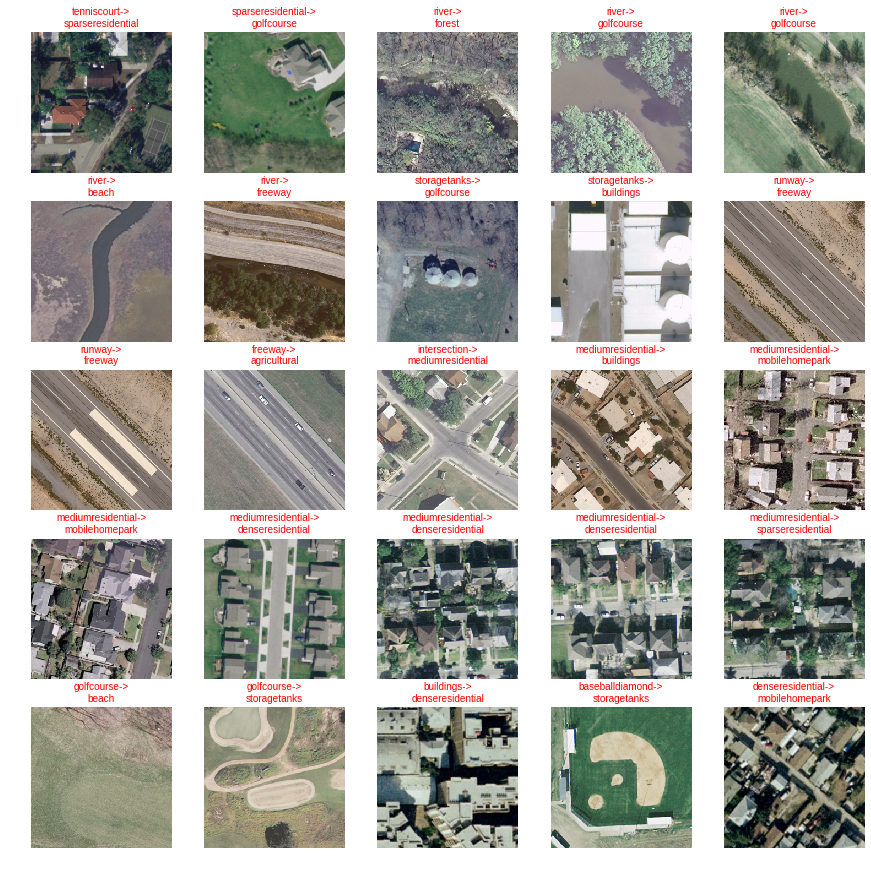

('mediumresidential->denseresidential', 3)
('denseresidential->mobilehomepark', 3)
('denseresidential->mediumresidential', 3)
('river->golfcourse', 2)
('runway->freeway', 2)
('mediumresidential->mobilehomepark', 2)
('tenniscourt->sparseresidential', 1)
('sparseresidential->golfcourse', 1)
('river->forest', 1)
('river->beach', 1)
('river->freeway', 1)
('storagetanks->golfcourse', 1)
('storagetanks->buildings', 1)
('freeway->agricultural', 1)
('intersection->mediumresidential', 1)
('mediumresidential->buildings', 1)
('mediumresidential->sparseresidential', 1)
('golfcourse->beach', 1)
('golfcourse->storagetanks', 1)
('buildings->denseresidential', 1)
('baseballdiamond->storagetanks', 1)
('denseresidential->tenniscourt', 1)


In [0]:
# plot up to 25 misclassified images
plotMisclassifications(pred)

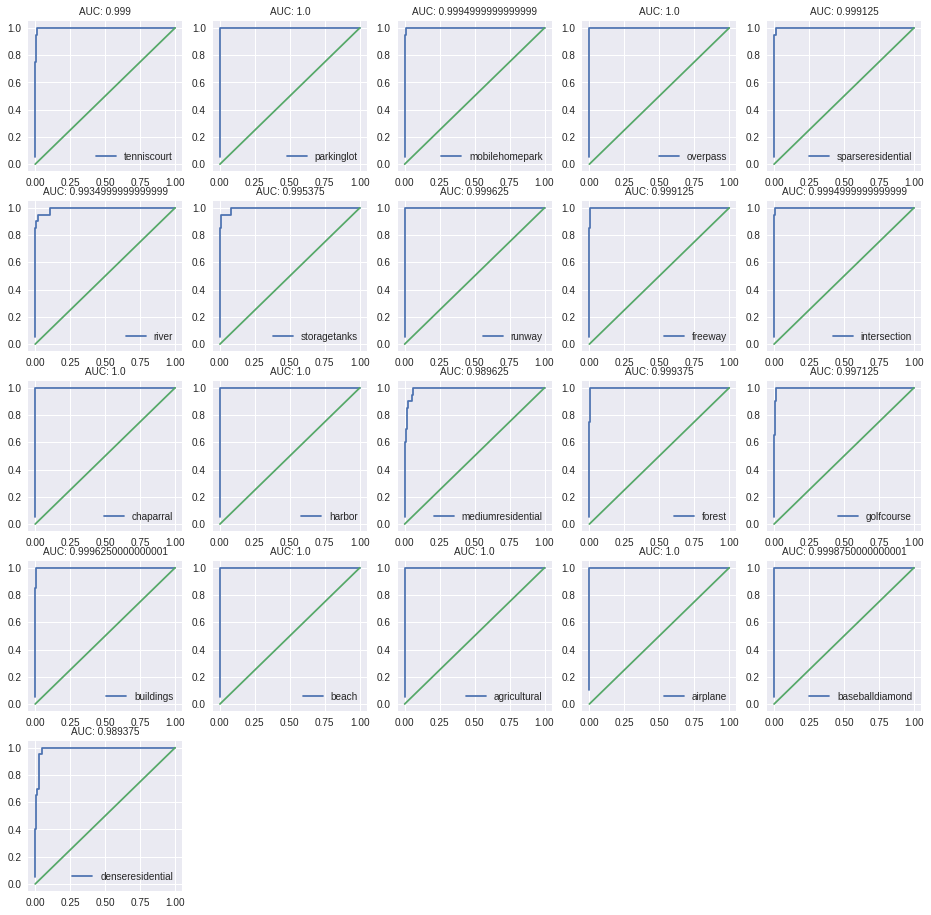

In [0]:
# generate ROC curve for each class
y_label, y_1hotlabel, y_pred, y_pred_prob, image = pred
plotROC(np.array(y_1hotlabel), np.array(y_pred_prob), len(class_labels))

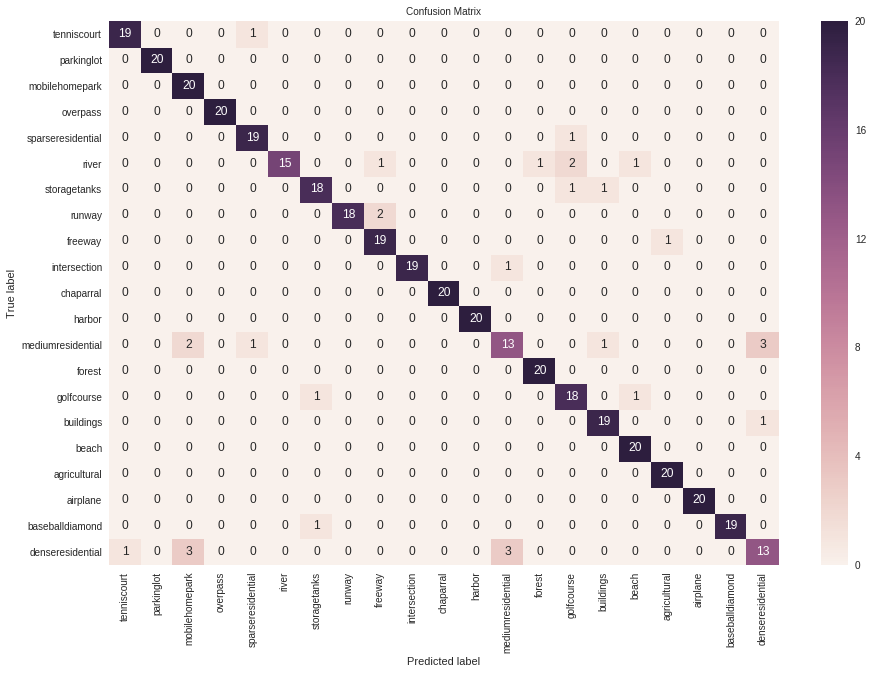

In [0]:
# generate confusion matrix heatmap
plotConfusionMatrix(y_label, y_pred)

In [0]:
del model1

### VGG16 Transfer Learning: Non-Static

In [0]:
# build another CNN with transfer learning using VGG16
model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dense(21, activation="sigmoid"))
conv_base.trainable = True
model2.summary()

# compile model
model2.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])
# load model weights
model2.load_weights('VGGTransferLearning2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_4 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
# use model to predict on test images
pred = generate_predictions(model2, test_generator)

Accuracy score:  0.680952380952381


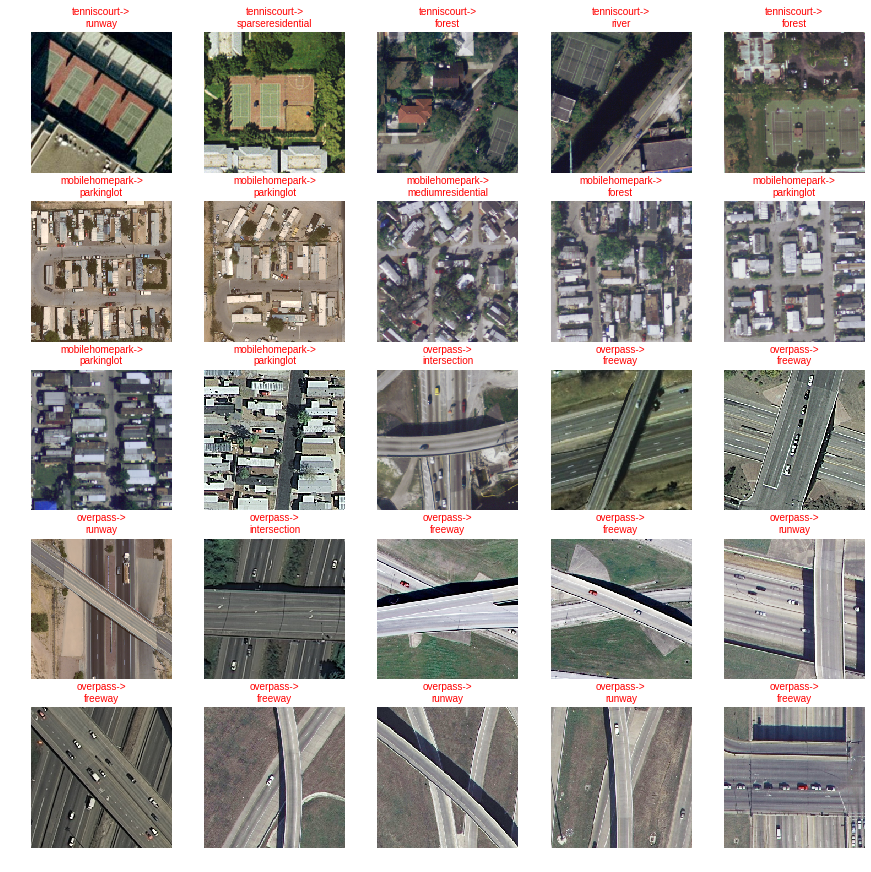

('denseresidential->mediumresidential', 13)
('airplane->sparseresidential', 9)
('overpass->freeway', 7)
('storagetanks->golfcourse', 7)
('intersection->river', 6)
('mediumresidential->forest', 6)
('mobilehomepark->parkinglot', 5)
('overpass->runway', 4)
('sparseresidential->golfcourse', 4)
('storagetanks->sparseresidential', 4)
('buildings->runway', 4)
('airplane->golfcourse', 4)
('denseresidential->sparseresidential', 4)
('river->forest', 3)
('intersection->mediumresidential', 3)
('agricultural->chaparral', 3)
('denseresidential->parkinglot', 3)
('tenniscourt->forest', 2)
('overpass->intersection', 2)
('sparseresidential->forest', 2)
('runway->freeway', 2)
('intersection->parkinglot', 2)
('golfcourse->agricultural', 2)
('buildings->freeway', 2)
('buildings->mediumresidential', 2)
('tenniscourt->runway', 1)
('tenniscourt->sparseresidential', 1)
('tenniscourt->river', 1)
('mobilehomepark->mediumresidential', 1)
('mobilehomepark->forest', 1)
('river->agricultural', 1)
('storagetanks->bas

In [0]:
# plot up to 25 misclassified images
plotMisclassifications(pred)

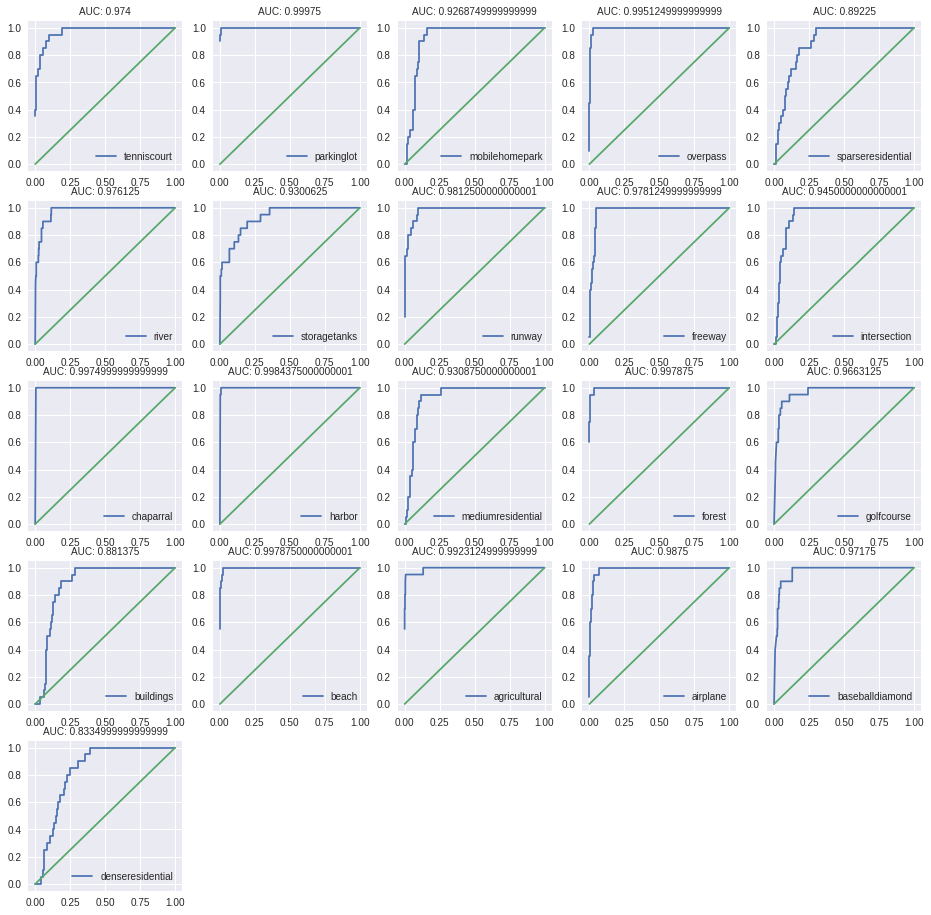

In [0]:
# generate ROC curve for each class
y_label, y_1hotlabel, y_pred, y_pred_prob, image = pred
plotROC(np.array(y_1hotlabel), np.array(y_pred_prob), len(class_labels))

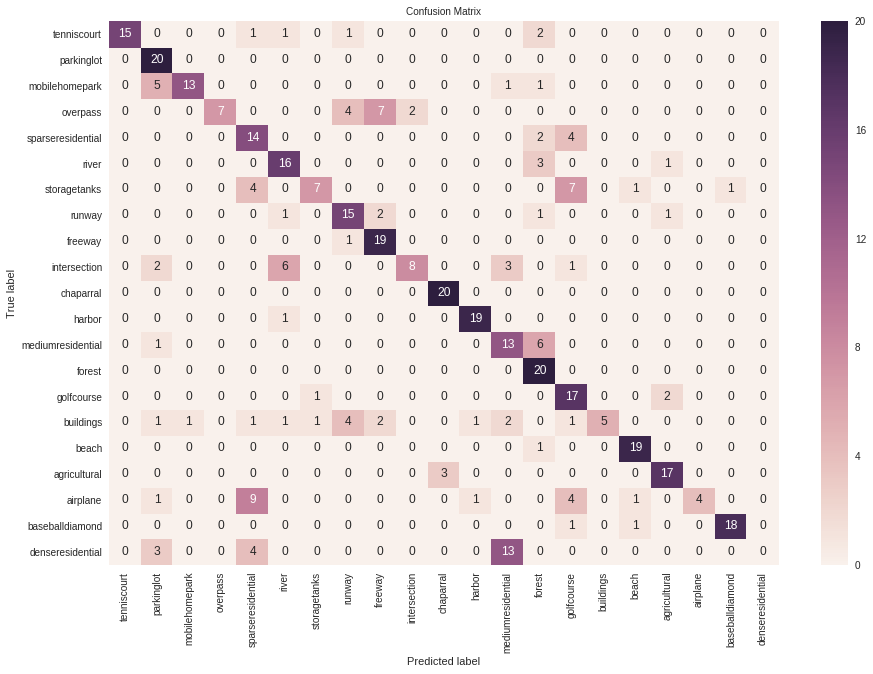

In [0]:
# generate confusion matrix heatmap
plotConfusionMatrix(y_label, y_pred)

In [0]:
del model2

### Fully Trained CNN

In [0]:
# build a CNN from scratch without transfer learning
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(256, 256, 3)))
model3.add(Conv2D(filters = 32, kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model3.add(MaxPooling2D(pool_size=(5,5)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(21, activation='softmax'))
model3.summary()

# compile model
model3.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])
# load model weights
model3.load_weights('CNNmod3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               20480256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [0]:
# use model to predict on test images
pred = generate_predictions(model3, test_generator)

Accuracy score:  0.7047619047619048


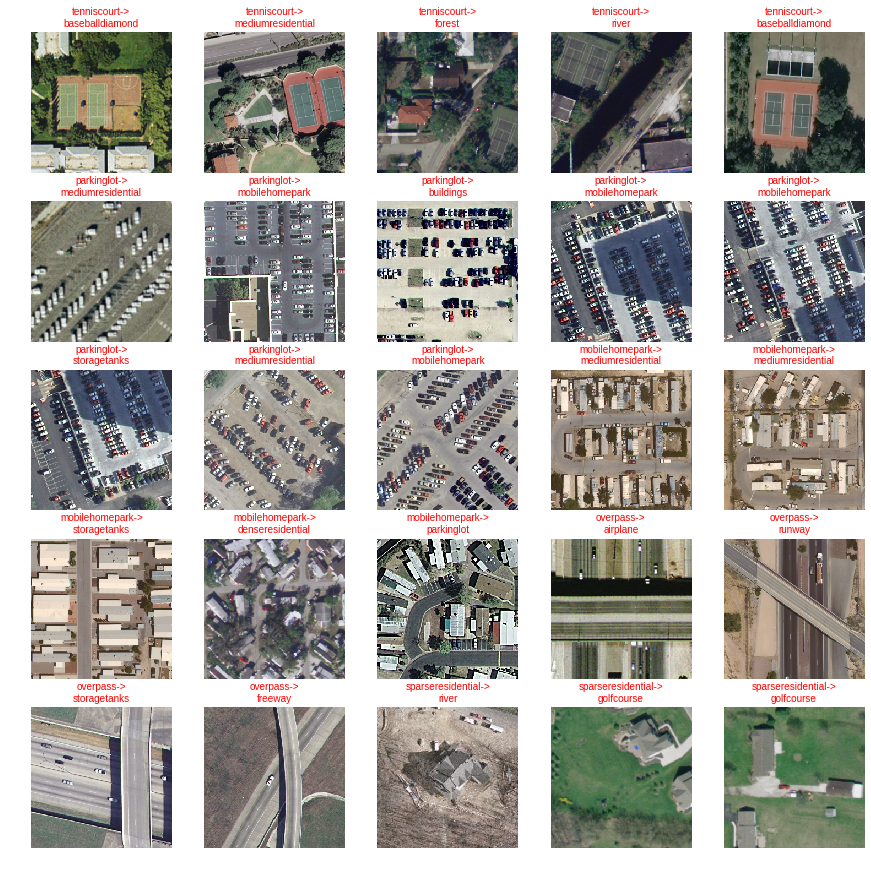

('parkinglot->mobilehomepark', 4)
('storagetanks->buildings', 4)
('mediumresidential->denseresidential', 4)
('sparseresidential->river', 3)
('sparseresidential->golfcourse', 3)
('river->agricultural', 3)
('storagetanks->freeway', 3)
('buildings->denseresidential', 3)
('buildings->freeway', 3)
('agricultural->forest', 3)
('airplane->tenniscourt', 3)
('denseresidential->mediumresidential', 3)
('tenniscourt->baseballdiamond', 2)
('parkinglot->mediumresidential', 2)
('mobilehomepark->mediumresidential', 2)
('storagetanks->sparseresidential', 2)
('runway->airplane', 2)
('intersection->tenniscourt', 2)
('intersection->river', 2)
('mediumresidential->agricultural', 2)
('mediumresidential->buildings', 2)
('mediumresidential->tenniscourt', 2)
('golfcourse->sparseresidential', 2)
('buildings->storagetanks', 2)
('agricultural->golfcourse', 2)
('agricultural->baseballdiamond', 2)
('airplane->sparseresidential', 2)
('airplane->storagetanks', 2)
('baseballdiamond->golfcourse', 2)
('denseresidential-

In [0]:
# plot up to 25 misclassified images
plotMisclassifications(pred)

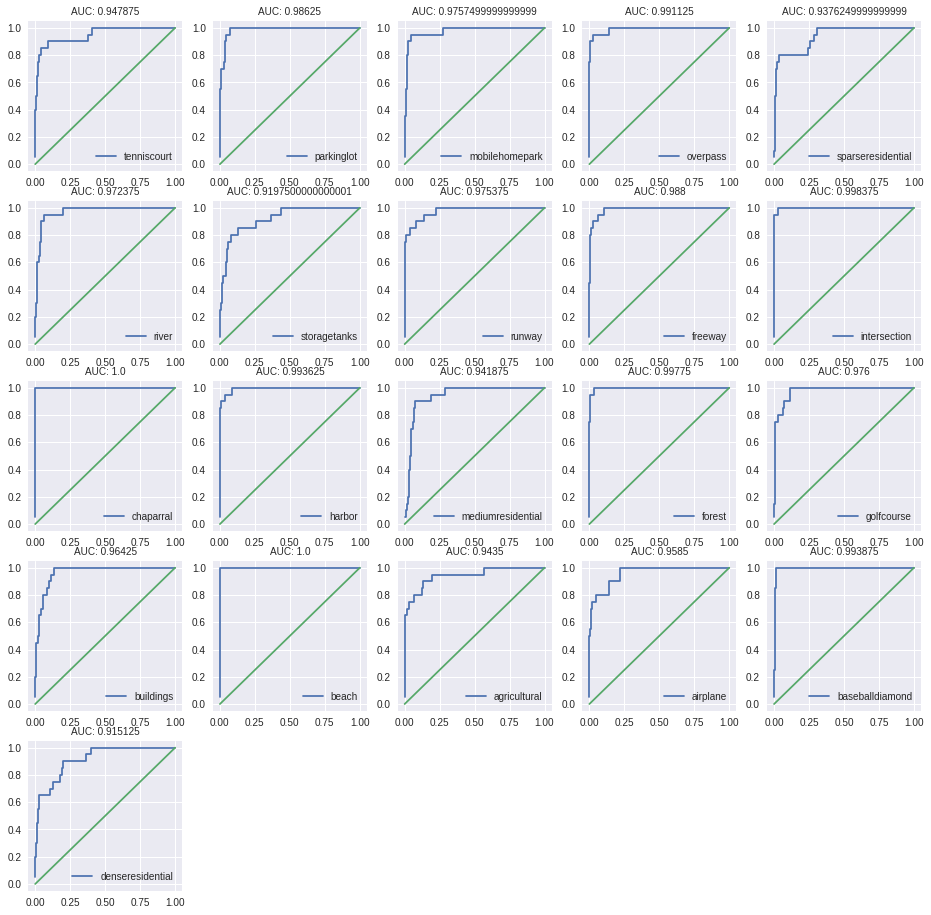

In [0]:
# generate ROC curve for each class
y_label, y_1hotlabel, y_pred, y_pred_prob, image = pred
plotROC(np.array(y_1hotlabel), np.array(y_pred_prob), len(class_labels))

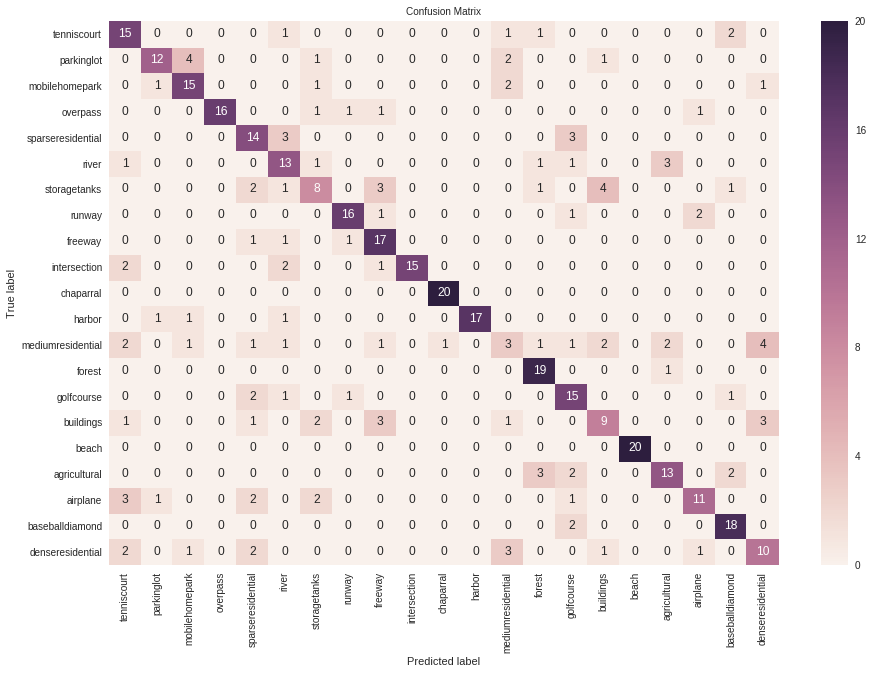

In [0]:
# generate confusion matrix heatmap
plotConfusionMatrix(y_label, y_pred)

In [0]:
del model3

### Inception Transfer Learning: Static

In [0]:
from keras.applications.inception_v3 import InceptionV3

In [15]:
# build CNN with transfer learning using InceptionV3
conv_base = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
model4 = Sequential()
model4.add(conv_base)
model4.add(Flatten())
model4.add(Dense(256, activation="relu"))
model4.add(Dense(21, activation="softmax"))
# fix base weights
conv_base.trainable = False
# check new number of trainable parameters
model4.summary()

# compile model
model4.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])
# load model weights
model4.load_weights('InceptionTransferLearning.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 40,682,805
Trainable params: 18,880,021
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
# use model to predict on test images
pred = generate_predictions(model4, test_generator)

Accuracy score:  0.7785714285714286


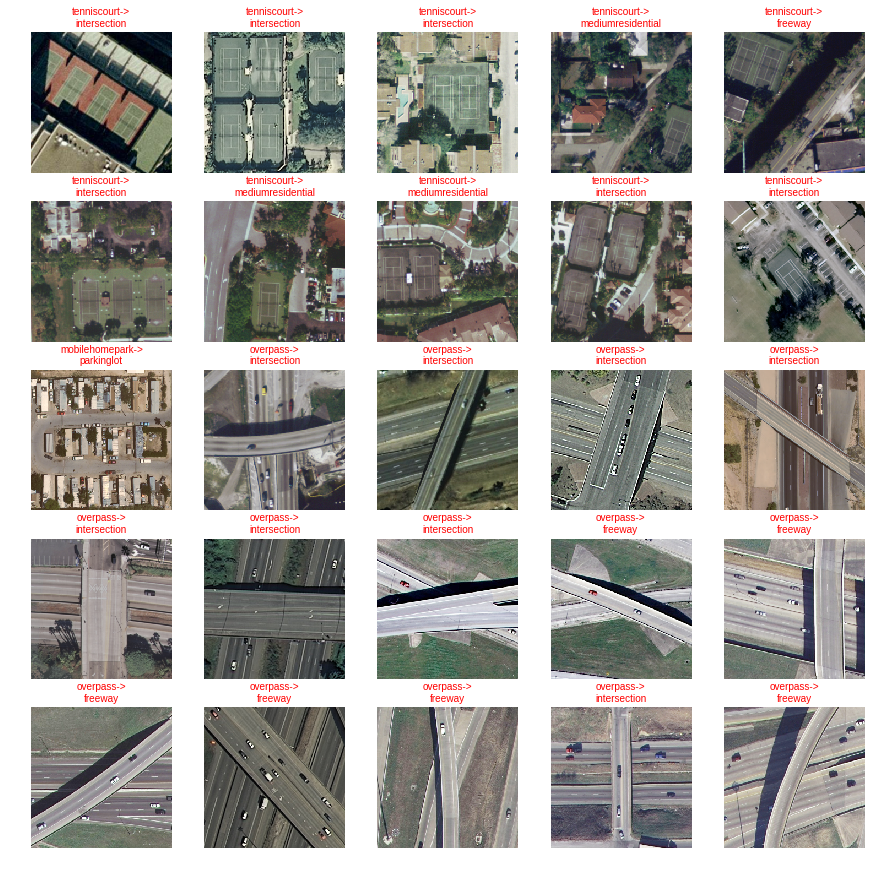

('overpass->intersection', 9)
('runway->freeway', 7)
('tenniscourt->intersection', 6)
('overpass->freeway', 6)
('mediumresidential->denseresidential', 6)
('sparseresidential->intersection', 5)
('buildings->intersection', 5)
('golfcourse->river', 4)
('tenniscourt->mediumresidential', 3)
('sparseresidential->mediumresidential', 3)
('buildings->denseresidential', 3)
('buildings->mobilehomepark', 3)
('denseresidential->mediumresidential', 3)
('storagetanks->intersection', 2)
('forest->river', 2)
('golfcourse->baseballdiamond', 2)
('buildings->storagetanks', 2)
('buildings->mediumresidential', 2)
('denseresidential->intersection', 2)
('tenniscourt->freeway', 1)
('mobilehomepark->parkinglot', 1)
('river->freeway', 1)
('storagetanks->mobilehomepark', 1)
('storagetanks->mediumresidential', 1)
('runway->river', 1)
('chaparral->agricultural', 1)
('harbor->parkinglot', 1)
('mediumresidential->parkinglot', 1)
('buildings->parkinglot', 1)
('beach->runway', 1)
('beach->river', 1)
('beach->freeway', 

In [17]:
# plot up to 25 misclassified images
plotMisclassifications(pred)

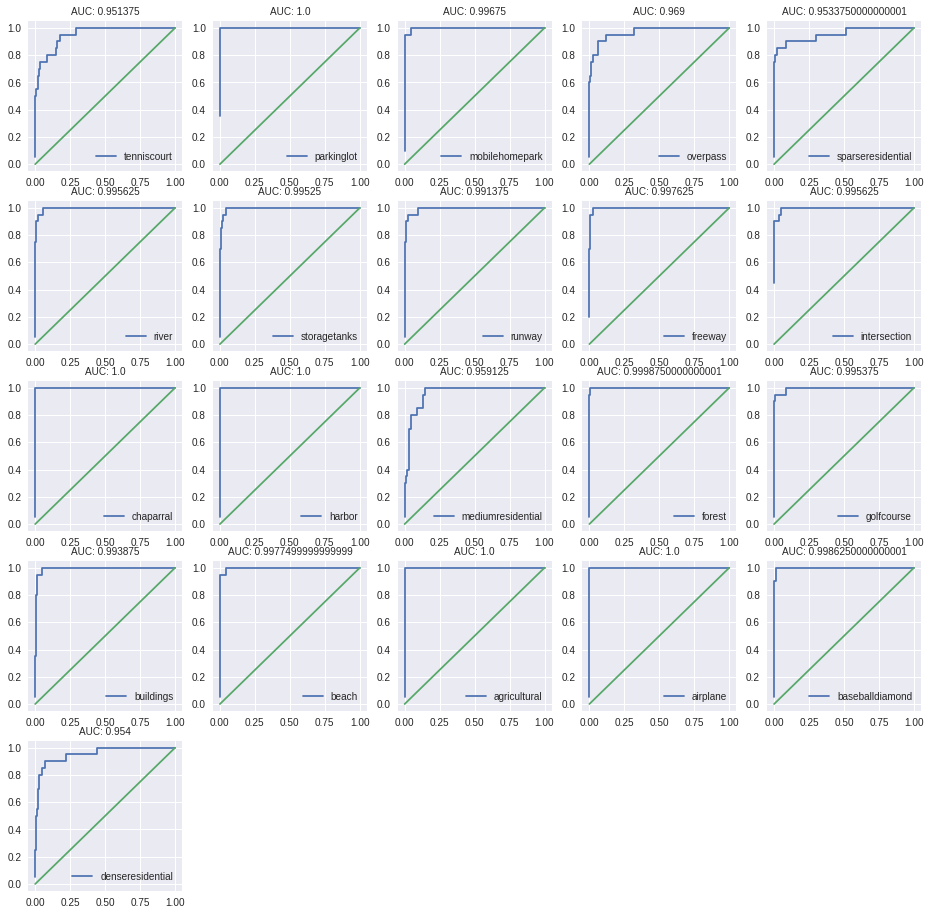

In [18]:
# generate ROC curve for each class
y_label, y_1hotlabel, y_pred, y_pred_prob, image = pred
plotROC(np.array(y_1hotlabel), np.array(y_pred_prob), len(class_labels))

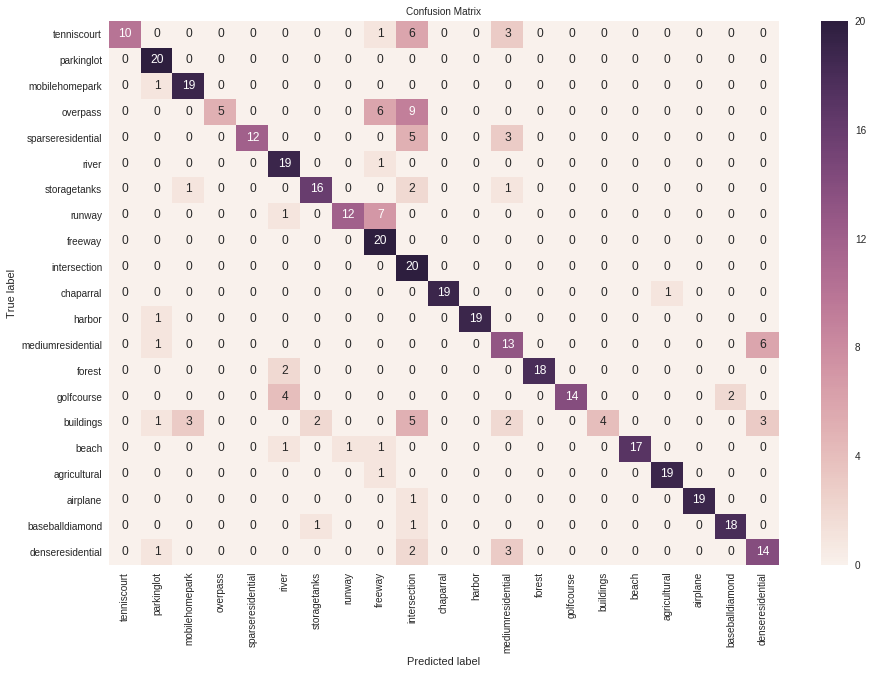

In [19]:
# generate confusion matrix heatmap
plotConfusionMatrix(y_label, y_pred)

In [0]:
del model4

### Inception Transfer Learning: Non-Static

In [21]:
# build another CNN with transfer learning using InceptionV3
model5 = Sequential()
model5.add(conv_base)
model5.add(Flatten())
model5.add(Dense(256, activation="relu"))
model5.add(Dense(21, activation="softmax"))
# have non static base weights
conv_base.trainable = True
model5.summary()

# compile model
model5.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])
# load model weights
model5.load_weights('InceptionTransferLearning2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dense_4 (Dense)              (None, 21)                5397      
Total params: 40,682,805
Trainable params: 40,648,373
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
# use model to predict on test images
pred = generate_predictions(model5, test_generator)

Accuracy score:  0.9476190476190476


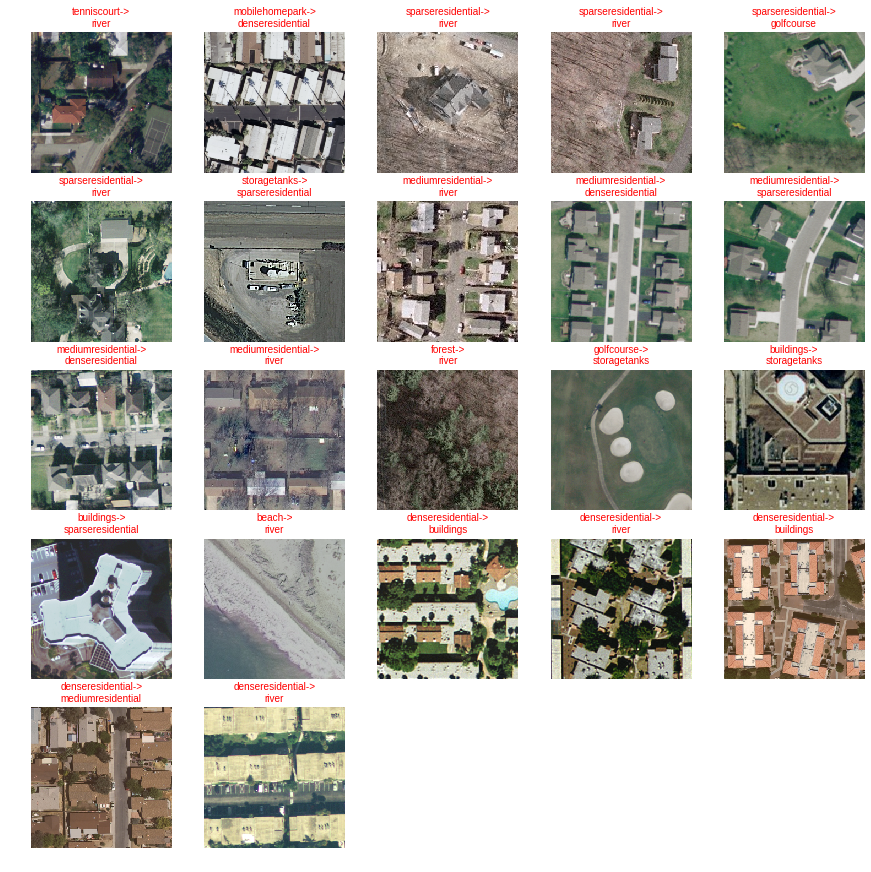

('sparseresidential->river', 3)
('mediumresidential->river', 2)
('mediumresidential->denseresidential', 2)
('denseresidential->buildings', 2)
('denseresidential->river', 2)
('tenniscourt->river', 1)
('mobilehomepark->denseresidential', 1)
('sparseresidential->golfcourse', 1)
('storagetanks->sparseresidential', 1)
('mediumresidential->sparseresidential', 1)
('forest->river', 1)
('golfcourse->storagetanks', 1)
('buildings->storagetanks', 1)
('buildings->sparseresidential', 1)
('beach->river', 1)
('denseresidential->mediumresidential', 1)


In [23]:
# plot up to 25 misclassified images
plotMisclassifications(pred)

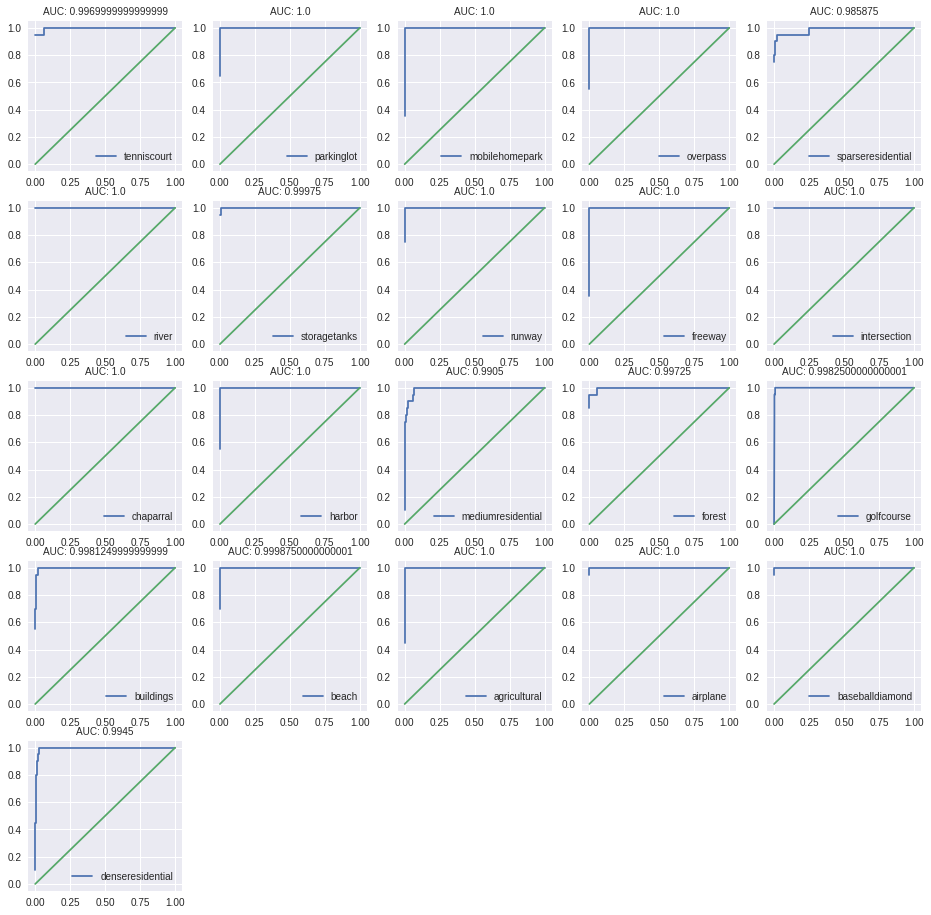

In [24]:
# generate ROC curve for each class
y_label, y_1hotlabel, y_pred, y_pred_prob, image = pred
plotROC(np.array(y_1hotlabel), np.array(y_pred_prob), len(class_labels))

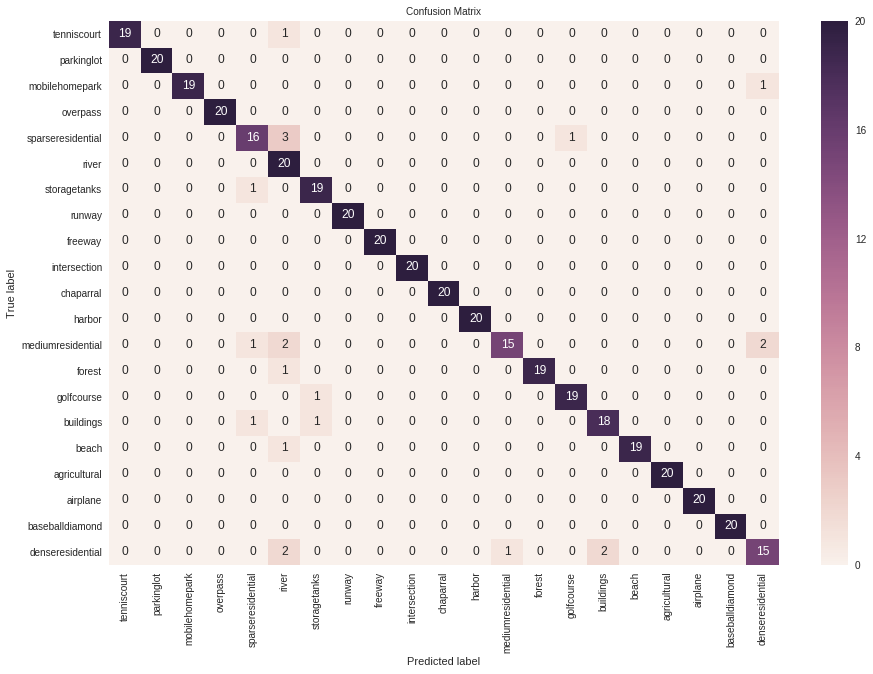

In [25]:
# generate confusion matrix heatmap
plotConfusionMatrix(y_label, y_pred)

In [0]:
del model5